# SET UP

In [1]:
install.packages("readr")  
library(readr)             
install.packages("dplyr")              
library(dplyr)
install.packages("caret")
library(caret)
df <- read_csv("../input/datasets-for-churn-telecom/cell2celltrain.csv")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘vctrs’


Warning message in install.packages("dplyr"):
“installation of package ‘vctrs’ had non-zero exit status”
Warning message in install.packages("dplyr"):
“installation of package ‘dplyr’ had non-zero exit status”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress


Rows: 51047 Columns: 58
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (23): C

# Data Cleaning and Preprocessing

In [2]:
# Delete unnecessary columns
df <- select(df, -c(CustomerID, ServiceArea, PrizmCode, Occupation, NonUSTravel, Homeownership, HandsetPrice, CreditRating, MaritalStatus))

# Drop Na variables
df<-na.omit(df)

In [3]:
# convert categorical variable to numerical
mapping <- c("No" = 0, "Yes" = 1)
columns_to_convert <- c("Churn", "ChildrenInHH", "HandsetRefurbished", "HandsetWebCapable", "TruckOwner", "RVOwner", "BuysViaMailOrder", "RespondsToMailOffers", "OptOutMailings", "OwnsComputer", "HasCreditCard", "OwnsMotorcycle", "MadeCallToRetentionTeam", "NotNewCellphoneUser", "NewCellphoneUser")  # Add all the column names that need conversion

# Iterate over the columns and apply the mapping
for (column in columns_to_convert) {
  df[[column]] <- ifelse(df[[column]] %in% names(mapping), mapping[df[[column]]], df[[column]])
}
str(df)

tibble [49,776 × 49] (S3: tbl_df/tbl/data.frame)
 $ Churn                    : num [1:49776] 1 1 0 0 1 0 0 0 0 0 ...
 $ MonthlyRevenue           : num [1:49776] 24 17 38 82.3 17.1 ...
 $ MonthlyMinutes           : num [1:49776] 219 10 8 1312 0 ...
 $ TotalRecurringCharge     : num [1:49776] 22 17 38 75 17 52 30 66 35 75 ...
 $ DirectorAssistedCalls    : num [1:49776] 0.25 0 0 1.24 0 0.25 0.25 2.48 0 0 ...
 $ OverageMinutes           : num [1:49776] 0 0 0 0 0 0 0 0 0 0 ...
 $ RoamingCalls             : num [1:49776] 0 0 0 0 0 0 0 0 0 0 ...
 $ PercChangeMinutes        : num [1:49776] -157 -4 -2 157 0 148 60 24 20 43 ...
 $ PercChangeRevenues       : num [1:49776] -19 0 0 8.1 -0.2 -3.1 4 6.8 -0.3 2.4 ...
 $ DroppedCalls             : num [1:49776] 0.7 0.3 0 52 0 9 0 0 0 0 ...
 $ BlockedCalls             : num [1:49776] 0.7 0 0 7.7 0 1.7 1 0.3 0 0 ...
 $ UnansweredCalls          : num [1:49776] 6.3 2.7 0 76 0 13 2.3 4 1 0 ...
 $ CustomerCareCalls        : num [1:49776] 0 0 0 4.3 0 0.7 0 4 

corrplot 0.92 loaded



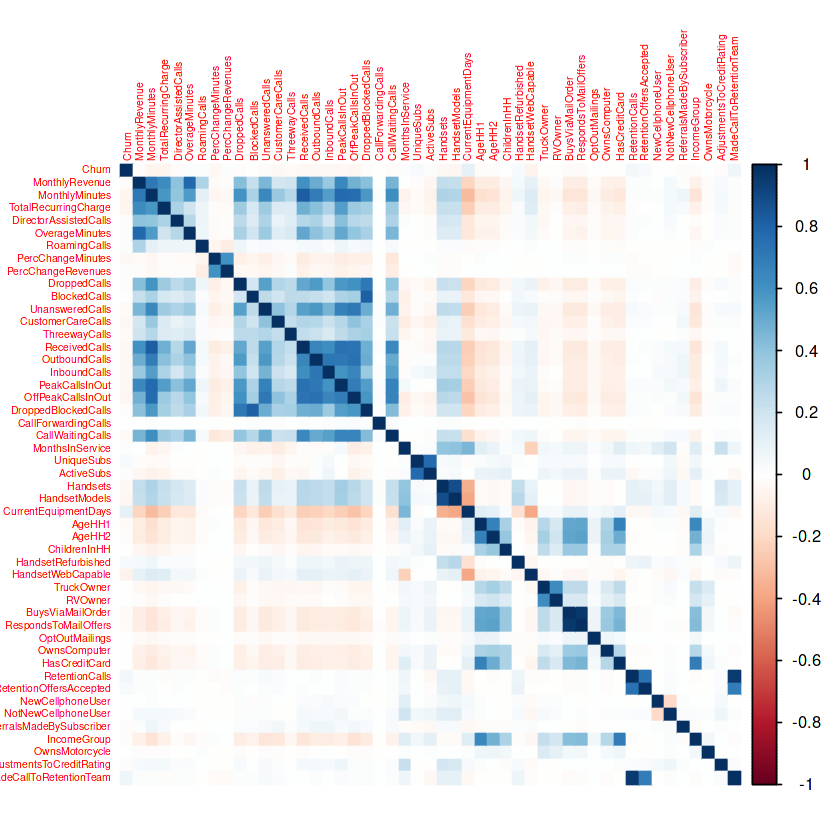

In [4]:
# Plot the correlation matrix as a heatmap
library(corrplot)
cor_matrix <- cor(df)
corrplot(cor_matrix, method = "color", tl.cex = 0.5)

In [5]:
# Select variables for classification models
myData <- df[, c("Churn", "AgeHH1", "AgeHH2", "ChildrenInHH", "BlockedCalls","IncomeGroup", "CustomerCareCalls", "HandsetWebCapable")]
# Set target variable as factor
myData$Churn <- factor(myData$Churn)
myData$ChildrenInHH <- factor(myData$ChildrenInHH)
myData$IncomeGroup <- factor(myData$IncomeGroup)
myData$HandsetWebCapable <- factor(myData$HandsetWebCapable)

# Data Modelling for Churn Customer Prediction

In [6]:
# Load libraries
library(tidyverse)
library(caret)
library(randomForest)
library(ROSE)
library(smotefamily)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ purrr::lift()     masks caret::lift()
✖ caret::progress() masks httr::progress()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine


Loaded ROSE 0.0-4




In [7]:
# Set seed for reproducibility
set.seed(1)

# Split the data into training and validation sets
trainIndex <- createDataPartition(myData$Churn, p = 0.7, list = FALSE)
trainSet <- myData[trainIndex, ]
validationSet <- myData[-trainIndex, ]
str(trainSet)

tibble [34,844 × 8] (S3: tbl_df/tbl/data.frame)
 $ Churn            : Factor w/ 2 levels "0","1": 2 1 1 2 1 1 1 1 1 1 ...
 $ AgeHH1           : num [1:34844] 62 26 30 46 28 52 46 46 0 99 ...
 $ AgeHH2           : num [1:34844] 0 26 0 54 0 58 46 68 0 0 ...
 $ ChildrenInHH     : Factor w/ 2 levels "0","1": 1 2 1 1 1 1 2 1 1 1 ...
 $ BlockedCalls     : num [1:34844] 0.7 0 7.7 0 1.7 1 0.3 0 0 0 ...
 $ IncomeGroup      : Factor w/ 10 levels "0","1","2","3",..: 5 7 7 10 2 10 7 6 8 4 ...
 $ CustomerCareCalls: num [1:34844] 0 0 4.3 0 0.7 0 4 0 0 3.7 ...
 $ HandsetWebCapable: Factor w/ 2 levels "0","1": 2 1 2 1 2 2 2 2 2 2 ...
 - attr(*, "na.action")= 'omit' Named int [1:1271] 63 88 92 123 127 146 228 250 297 307 ...
  ..- attr(*, "names")= chr [1:1271] "63" "88" "92" "123" ...


In [8]:
# compute square roote of number of predictors to use as input for 
# randomForest() function calls
sqrt.num.vars <- floor(sqrt(ncol(trainSet[, -1])))

In [9]:
# now fit randomForest on original (imbalanced) data
table(trainSet$Churn) # observe imbalancedness 
table(trainSet$Churn)/nrow(trainSet) # imbalancedness in proportional terms


    0     1 
24864  9980 


        0         1 
0.7135805 0.2864195 

In [10]:
set.seed(1) # for replicability and so that each randomForest call uses the same seed 
fit_RF_orig_data <- randomForest(Churn~.,data=trainSet, ntree=100, mtry=sqrt.num.vars)

In [11]:
# predict classes using default cutoff of 0.5 using this fit
pred_RF_orig_data <-  predict(fit_RF_orig_data, newdata = validationSet)

In [12]:
# predict classes using cutoff = prevalence (proportion of positive class in training data)
prev = sum(trainSet$Churn==1)/nrow(trainSet)
pred_prob_RF_orig_data = predict(fit_RF_orig_data, newdata = validationSet, type = 'prob')
pred_RF_orig_data_altCutoff = ifelse(pred_prob_RF_orig_data[ ,2] > prev, 1, 0)

In [13]:
# next, fit randomForest using the Random Undersampling technique
set.seed(1)
randomUndersamp_trainSet <- ovun.sample(Churn~., data=trainSet, method="under", 
                                        N = 2*sum(trainSet$Churn==1)) 
# N is desired the size of the resulting dataset
# for undersampling we want each class to have the 
# number of observations of the minority class 
# (here y = 1 is the minority class)

In [14]:
table(randomUndersamp_trainSet$data$Churn)
set.seed(1)
fit_RF_randomUndersamp <- randomForest(Churn~.,
                                       data=randomUndersamp_trainSet$data, ntree=200, mtry=sqrt.num.vars) 
pred_RF_randomUndersamp <-  predict(fit_RF_randomUndersamp, newdata = validationSet)


   0    1 
9980 9980 

In [15]:
# next, fit randomForest using Random Oversampling
set.seed(1)
randomOversamp_trainSet <- ovun.sample(Churn~., data=trainSet, method="over", 
                                       N = 2*sum(trainSet$Churn==0))
# for oversampling we want each class to have the 
# number of observations of the majority class 
# (here y = 0 is the majority class)

In [16]:
table(randomOversamp_trainSet$data$Churn)
set.seed(1)
fit_RF_randomOversamp <- 
  randomForest(Churn~.,data=randomOversamp_trainSet$data, ntree=100, mtry=sqrt.num.vars) 
pred_RF_randomOversamp <-  predict(fit_RF_randomOversamp, newdata = validationSet)


    0     1 
24864 24864 

# Model Evaluation

In [17]:
# collate validationSet overall accuracy, sensitivity, specificity, 
# PPV and NPV into a table
validationResultsMatrix = matrix(data = NA, nrow = 4, ncol = 6)
colnames(validationResultsMatrix) = c('Method', 'Accuracy', 'Sensitivity', 
                                      'Specificity', 'PPV', 'NPV')
validationResultsMatrix[1, ] = c('Raw Imbalanced Data: Cutoff = 0.5',
                                 confusionMatrix(pred_RF_orig_data, validationSet$Churn, 
                                                 positive = "1")$overall[1] %>% round(., 3),
                                 confusionMatrix(pred_RF_orig_data, validationSet$Churn, 
                                                 positive = "1")$byClass[1:4] %>% round(., 3))
validationResultsMatrix[2, ] = 
  c('Raw Imbalanced Data: Cutoff = Prevalence',
    confusionMatrix(as.factor(pred_RF_orig_data_altCutoff), validationSet$Churn, 
                    positive = "1")$overall[1] %>% round(., 3),
    confusionMatrix(as.factor(pred_RF_orig_data_altCutoff), validationSet$Churn, 
                    positive = "1")$byClass[1:4] %>% round(., 3))
validationResultsMatrix[3, ] = c('Random Undersampling Majority Class',
                                 confusionMatrix(pred_RF_randomUndersamp, validationSet$Churn, 
                                                 positive = "1")$overall[1] %>% round(., 3),
                                 confusionMatrix(pred_RF_randomUndersamp, validationSet$Churn, 
                                                 positive = "1")$byClass[1:4] %>% round(., 3))# Define the control parameters for KNN
validationResultsMatrix[4, ] = c('Random Oversampling Minority Class',
                                 confusionMatrix(pred_RF_randomOversamp, validationSet$Churn, 
                                                 positive = "1")$overall[1] %>% round(., 3),
                                 confusionMatrix(pred_RF_randomOversamp, validationSet$Churn, 
                                                 positive = "1")$byClass[1:4] %>% round(., 3))

View(validationResultsMatrix)

Method,Accuracy,Sensitivity,Specificity,PPV,NPV
Raw Imbalanced Data: Cutoff = 0.5,0.712,0.006,0.995,0.337,0.714
Raw Imbalanced Data: Cutoff = Prevalence,0.685,0.095,0.921,0.326,0.717
Random Undersampling Majority Class,0.54,0.511,0.552,0.314,0.738
Random Oversampling Minority Class,0.58,0.422,0.644,0.322,0.735


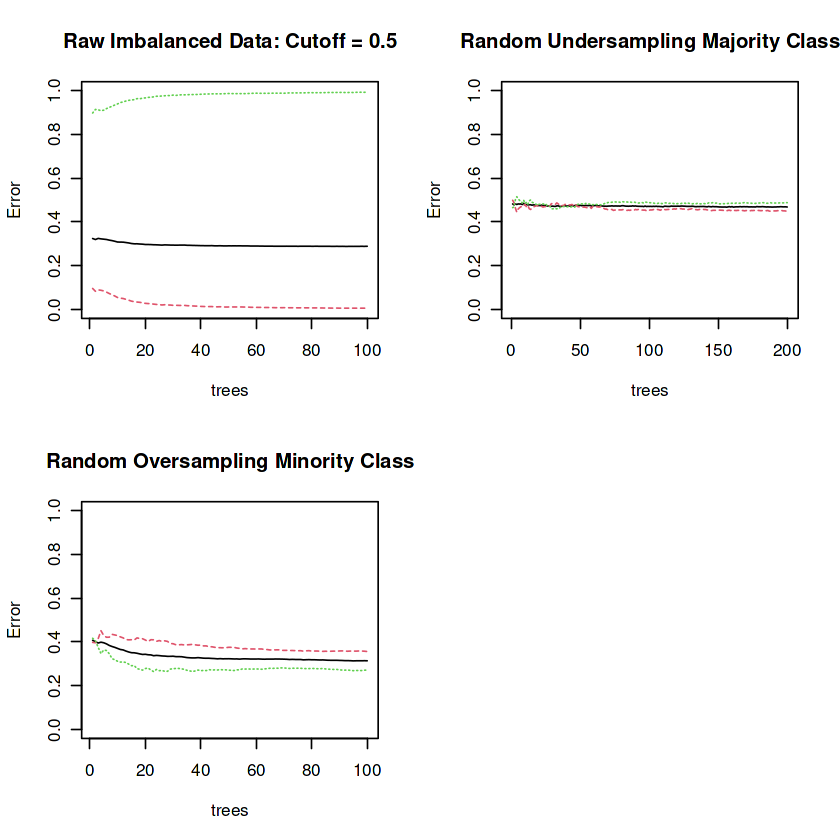

In [18]:
# view OOB error rate plots for the randomForest() fits
par(mfrow = c(2,2))
plot(fit_RF_orig_data, ylim = c(0,1), main = 'Raw Imbalanced Data: Cutoff = 0.5')
plot(fit_RF_randomUndersamp, ylim = c(0,1), main = 'Random Undersampling Majority Class')
plot(fit_RF_randomOversamp, ylim = c(0,1), main = 'Random Oversampling Minority Class')
par(mfrow = c(1,1))

# Conclusion
The goal is to predict customers who are most likely to churn (churn customer is the positive class). Hence, model accuracy and sensitivity is prioritised. Based on the evaluation results above, we should use undersampling method as it produces the highest accuracy and sensitity.